<B span  style="color: red; font-size: 40px;" ></span>

<B span style="color: red; font-size: 30px;" >Import Libraries</span>

In [2]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Input, ReLU ,Conv2D, MaxPool2D, AvgPool2D , Reshape , Conv2DTranspose  , Activation, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import VGG16,EfficientNetB2,ResNet50,Xception

<B span style="color: red; font-size: 30px;" >Load Data</span>

In [3]:
no = os.listdir('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/no/')
yes = os.listdir('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes/')
print(len(no))
print(len(yes))

98
155


<B span style="color: red; font-size: 30px;" >Plot Brain Imgaes with Tumor</span>

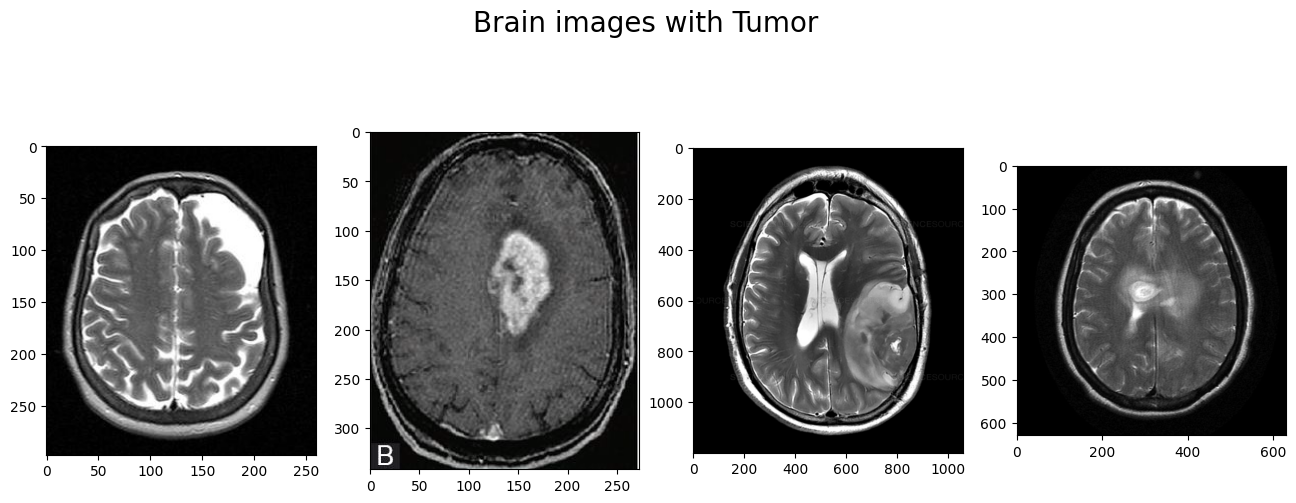

In [4]:
fig = plt.figure(figsize=(16,6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes'+ '/'+ yes[i])
    plt.imshow(img)
plt.suptitle("Brain images with Tumor",fontsize=20)
plt.show()

<B span style="color: red; font-size: 30px;" >Plot Brain Imgaes with No Tumor</span>

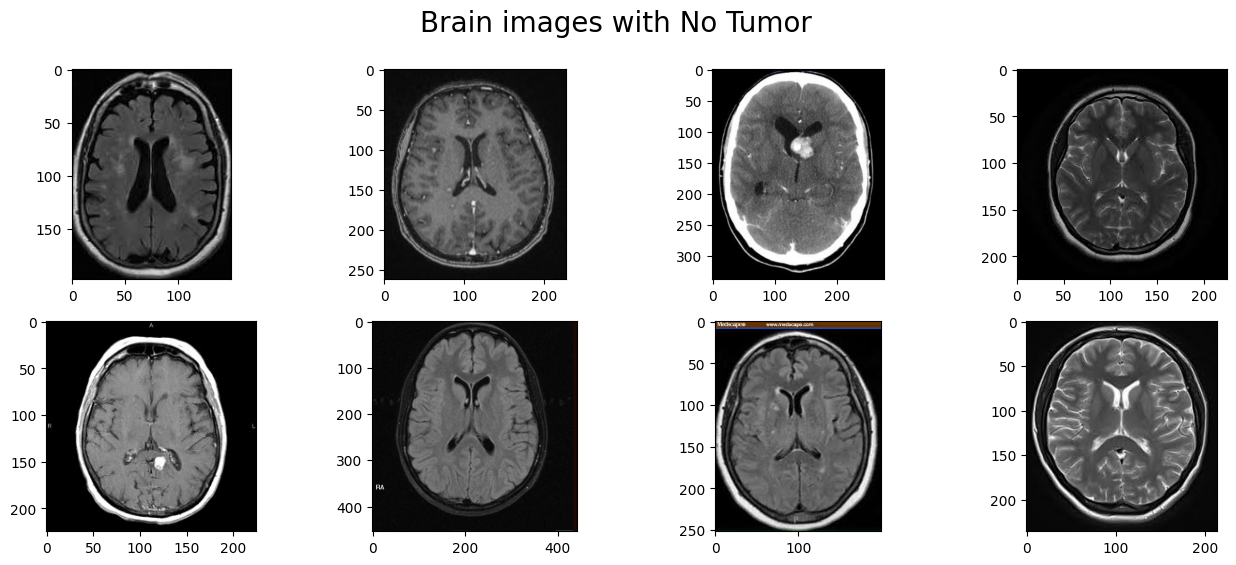

In [5]:
fig = plt.figure(figsize=(16,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = cv2.imread('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/no'+'/'+ no[i])
    plt.imshow(img)
plt.suptitle("Brain images with No Tumor",fontsize=20)
plt.show()

<B span style="color: red; font-size: 30px;" ></span>histogram equalization

In [6]:
IMG_SIZE = 128
def equalize(img):
    img = img.astype('uint8')
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    img = clahe.apply(img)
    img = np.expand_dims(img, 2)
    return img

In [7]:
def compare_equalized(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = equalize(img).squeeze()
    img2 = np.hstack([img, img2])
    plt.imshow(img2, cmap='gray')
    plt.show()

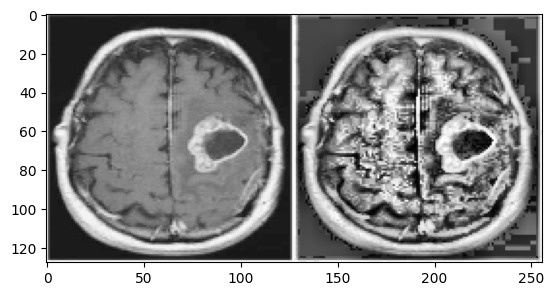

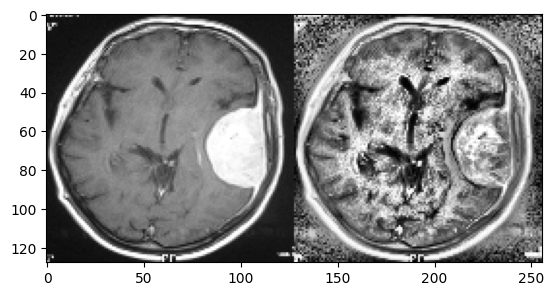

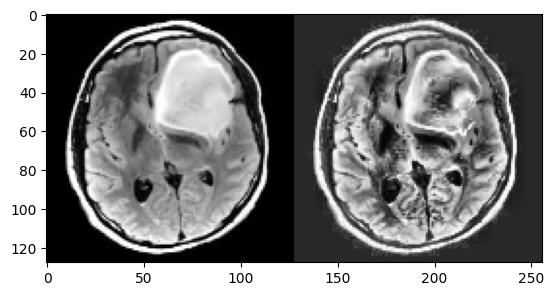

In [8]:
compare_equalized("/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes/Y10.jpg")
compare_equalized("/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes/Y103.jpg")
compare_equalized("/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes/Y105.jpg")

<B span style="color: red; font-size: 30px;" ></span>Reading dataset (image data generators)

In [15]:
IMG_SIZE = 128
DATA_DIR = '/kaggle/input/brain-tumor-dataset'
DIR = 'brain_tumor_dataset'
MODEL_PATH = 'saved-models/224-hist-binary2-more-train'

In [40]:
image_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, DIR_NO),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=128,
)
image_gen.save_to_dir

Found 253 images belonging to 2 classes.


<B span style="color: red; font-size: 30px;" >processing Data and Split</span>

In [46]:
labels = ['yes','no']
Classes = {'no':0, 'yes':1}

X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset'+'/',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = img / 255  
        X.append(img)
        y.append(Classes[i])

In [47]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((253, 128, 128, 3), (253,))

<B span style="color: red; font-size: 30px;" >Plot Target</span>

In [48]:
Class_series=pd.Series(y)
classes=["Tumor", "No Tumor"]
Tumor_or_not = Class_series.value_counts().tolist()
values = [Tumor_or_not[0], Tumor_or_not[1]]
fig = px.pie(values=Class_series.value_counts(), names=classes, width=700, height=400, 
             color_discrete_sequence=["skyblue","black"],title="percentage between Tumor & No Tumor")
fig.show()

<B span style="color: red; font-size: 30px;" >Plot Random Imgaes</span>

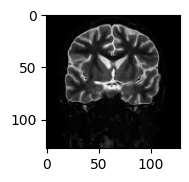

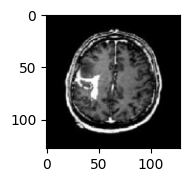

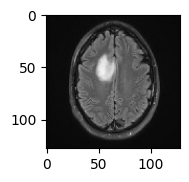

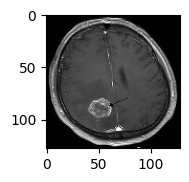

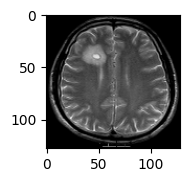

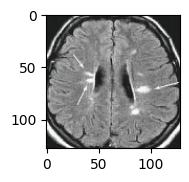

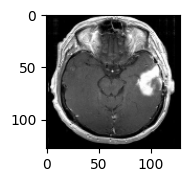

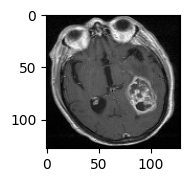

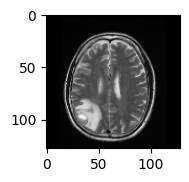

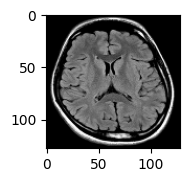

In [49]:
for i in range(10):
    img = np.random.randint(0,len(X))
    plt.figure(figsize=(10,10))
    plt.subplot(2, 5, i+1)
    plt.imshow(X[img])
plt.show()

<B span style="color: red; font-size: 30px;" ></span>Split data

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=44)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((202, 128, 128, 3), (202,), (51, 128, 128, 3), (51,))

<B span style="color: red; font-size: 30px;" ></span>GAN


In [71]:
# prepraing data
batch_size = 256

data = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/brain-tumor-dataset/brain_tumor_dataset',
    label_mode=None,
    batch_size=batch_size,
    image_size=(128,128))

Found 253 files belonging to 1 classes.


In [72]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [73]:
# Discriminator
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU", input_shape=(128,128,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model = Discriminator()
D_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)      

In [74]:
# optimizer
D_optm = Adam(1e-4)

In [75]:
latent_dim = 100

In [76]:
# Build the Generator function
def Generator():
  generator = Sequential()
  generator.add(Dense(units=4*4*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="ReLU"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))
  
  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))
  
    
  return generator


# a summary of the Generetor
G_model = Generator()
G_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              409600    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_10 (Ba  (None, 4, 4, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 128)         295040    
 Transpose)                                                      
                                                                 
 batch_normalization_11 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                      

In [77]:
# optimizer
G_optm = Adam(1e-4)

In [78]:
# creating random noise
random_noise = tf.random.normal([1,100])

In [79]:
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)

In [80]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.5000393]], shape=(1, 1), dtype=float32)


In [81]:
# The code of this cell is from keras sample.
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [82]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [83]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [84]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [85]:
# number of epochs
epochs = 100
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - d_loss: 0.6805 - g_loss: 0.6944
Epoch 2/100
1/1 [==============================] - 1s 540ms/step - d_loss: 0.6133 - g_loss: 0.6957
Epoch 3/100
1/1 [==============================] - 1s 522ms/step - d_loss: 0.5575 - g_loss: 0.6977
Epoch 4/100
1/1 [==============================] - 1s 519ms/step - d_loss: 0.5104 - g_loss: 0.7005
Epoch 5/100
1/1 [==============================] - 1s 503ms/step - d_loss: 0.4739 - g_loss: 0.7043
Epoch 6/100
1/1 [==============================] - 1s 509ms/step - d_loss: 0.4428 - g_loss: 0.7090
Epoch 7/100
1/1 [==============================] - 1s 504ms/step - d_loss: 0.4236 - g_loss: 0.7148
Epoch 8/100
1/1 [==============================] - 1s 510ms/step - d_loss: 0.4099 - g_loss: 0.7218
Epoch 9/100
1/1 [==============================] - 1s 510ms/step - d_loss: 0.3994 - g_loss: 0.7300
Epoch 10/100
1/1 [==============================] - 1s 501ms/step - d_loss: 0.3907 - g_loss: 0.7396
Epoch 11/100

In [86]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([128, 100])
# Generatine new images using the trained Generator model 
generated_images = G_model(noise, training=False)

In [87]:
# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5

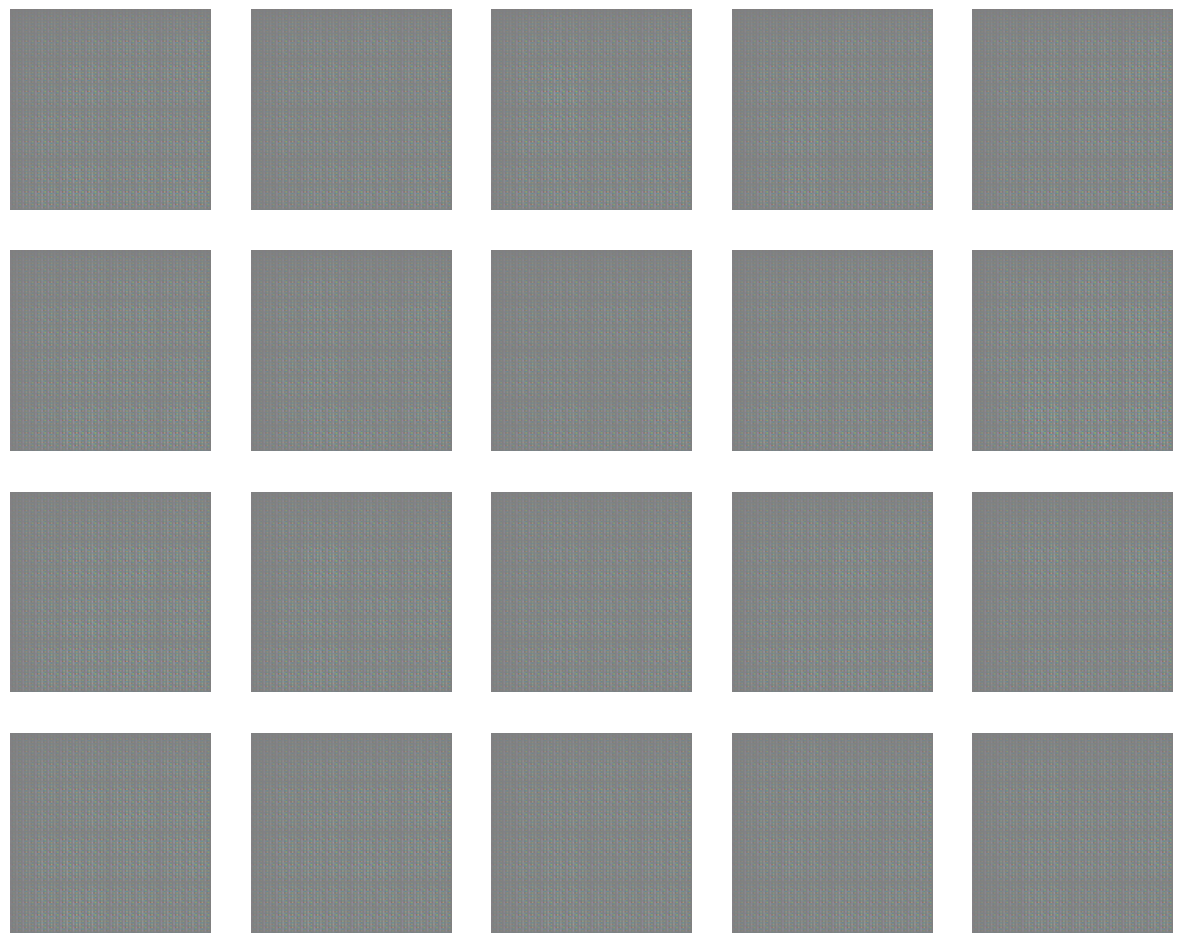

In [88]:
plt.figure(figsize=(15, 12))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

<B span style="color: red; font-size: 30px;" >Load The DenseNet121 Base Model </span>

In [89]:
base_model6 = tf.keras.applications.DenseNet121(input_shape=(128, 128, 3), weights='imagenet', include_top=False)
for layer in base_model6.layers:
    layer.trainable=False
base_model6.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

<B span style="color: red; font-size: 30px;" >Build The DenseNet121 Base Model </span>

In [90]:
number=len(pd.unique(y_train))
model6 = tf.keras.models.Sequential([
    base_model6,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(number, activation='softmax')
])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout_8 (Dropout)         (None, 4, 4, 1024)        0         
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               8389120   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 15427650 (58.85 MB)
Trainable params: 83

In [220]:
model6.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
temp=model6.fit(X_train,y_train,epochs=80)

Epoch 1/80


2023-12-16 15:35:40.574536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 7s 28ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 2/80
7/7 [==============================] - 0s 26ms/step - loss: 0.0106 - accuracy: 0.9901
Epoch 3/80
7/7 [==============================] - 0s 26ms/step - loss: 0.0056 - accuracy: 0.9950
Epoch 4/80
7/7 [==============================] - 0s 25ms/step - loss: 4.6480e-06 - accuracy: 1.0000
Epoch 5/80
7/7 [==============================] - 0s 25ms/step - loss: 0.0196 - accuracy: 0.9901
Epoch 6/80
7/7 [==============================] - 0s 25ms/step - loss: 0.0114 - accuracy: 0.9950
Epoch 7/80
7/7 [==============================] - 0s 25ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 8/80
7/7 [==============================] - 0s 26ms/step - loss: 0.0336 - accuracy: 0.9950
Epoch 9/80
7/7 [==============================] - 0s 25ms/step - loss: 0.0429 - accuracy: 0.9950
Epoch 10/80
7/7 [==============================] - 0s 26ms/step - loss: 0.1127 - accuracy: 0.9901
Epoch 11/80
7/7 [===================

In [221]:
score, acc = model6.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 2s 26ms/step - loss: 0.8581 - accuracy: 0.9020
Test Loss = 0.8580938577651978
Test Accuracy = 0.9019607901573181


In [222]:
hist6=pd.DataFrame(temp.history)
hist6

loss  accuracy
0   0.001192  1.000000
1   0.010601  0.990099
2   0.005561  0.995049
3   0.000005  1.000000
4   0.019555  0.990099
..       ...       ...
75  0.105367  0.985148
76  0.125332  0.980198
77  0.108579  0.980198
78  0.008029  0.995049
79  0.046854  0.980198

[80 rows x 2 columns]

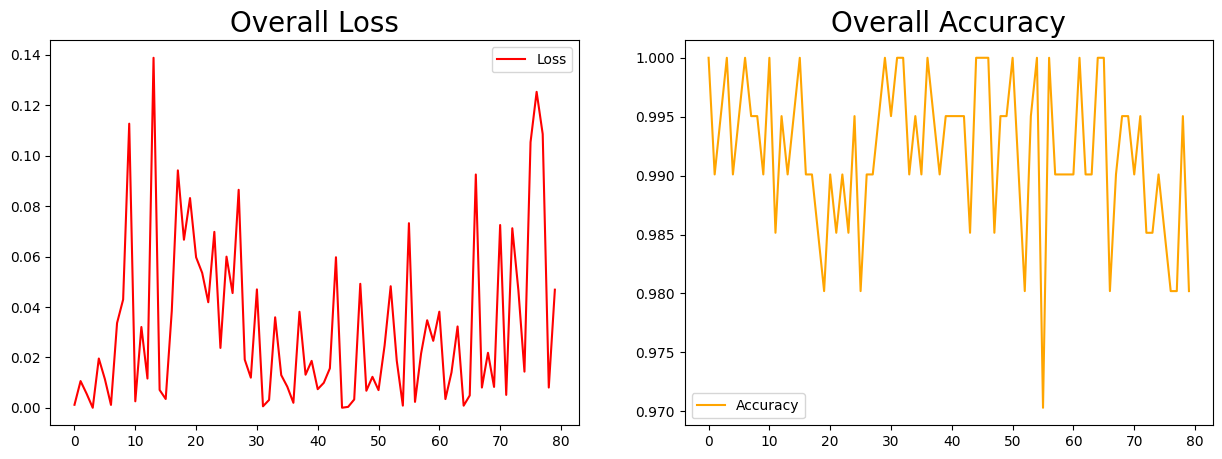

In [223]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist6['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist6['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" >ResNet 50</span>

In [95]:
resnet50_model3 = tf.keras.applications.ResNet50(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in resnet50_model3.layers:
    layer.trainable=False
resnet50_model3.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [192]:
class_num=len(pd.unique(y_train))
model3=keras.models.Sequential()
model3.add(resnet50_model3)
model3.add(keras.layers.Dropout(.5))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(512,activation=tf.nn.relu))
model3.add(keras.layers.Dropout(.5)) 
model3.add(keras.layers.Dense(class_num,activation='softmax'))
model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_22 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 flatten_15 (Flatten)        (None, 32768)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 40366466 (153.99 MB)
Trainable params: 

In [203]:
model3.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model3.fit(X_train,y_train,epochs=50)

Epoch 1/50


2023-12-16 15:33:06.899405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 4s 24ms/step - loss: 0.1625 - accuracy: 0.9208
Epoch 2/50
7/7 [==============================] - 0s 24ms/step - loss: 0.3412 - accuracy: 0.8713
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.2942 - accuracy: 0.8713
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.2950 - accuracy: 0.8713
Epoch 5/50
7/7 [==============================] - 0s 23ms/step - loss: 0.2490 - accuracy: 0.8663
Epoch 6/50
7/7 [==============================] - 0s 24ms/step - loss: 0.2619 - accuracy: 0.8713
Epoch 7/50
7/7 [==============================] - 0s 25ms/step - loss: 0.2436 - accuracy: 0.8960
Epoch 8/50
7/7 [==============================] - 0s 24ms/step - loss: 0.1996 - accuracy: 0.9208
Epoch 9/50
7/7 [==============================] - 0s 24ms/step - loss: 0.2384 - accuracy: 0.8861
Epoch 10/50
7/7 [==============================] - 0s 25ms/step - loss: 0.1822 - accuracy: 0.9455
Epoch 11/50
7/7 [=======================

In [204]:
score, acc = model3.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 1s 24ms/step - loss: 0.4844 - accuracy: 0.8431
Test Loss = 0.48442956805229187
Test Accuracy = 0.843137264251709


In [205]:
hist3=pd.DataFrame(hist.history)
hist3

loss  accuracy
0   0.162545  0.920792
1   0.341209  0.871287
2   0.294184  0.871287
3   0.295020  0.871287
4   0.249007  0.866337
5   0.261896  0.871287
6   0.243628  0.896040
7   0.199611  0.920792
8   0.238435  0.886139
9   0.182215  0.945545
10  0.199483  0.905941
11  0.216160  0.896040
12  0.207761  0.900990
13  0.253524  0.891089
14  0.205388  0.935644
15  0.212070  0.886139
16  0.305571  0.876238
17  0.222406  0.910891
18  0.211042  0.900990
19  0.238724  0.886139
20  0.214393  0.920792
21  0.226362  0.900990
22  0.259325  0.891089
23  0.179646  0.915842
24  0.189375  0.920792
25  0.186421  0.910891
26  0.215071  0.905941
27  0.211304  0.900990
28  0.237396  0.896040
29  0.291853  0.876238
30  0.185295  0.925743
31  0.210518  0.886139
32  0.301116  0.846535
33  0.198081  0.910891
34  0.209892  0.905941
35  0.231235  0.876238
36  0.227550  0.920792
37  0.311370  0.886139
38  0.216352  0.905941
39  0.264297  0.871287
40  0.243359  0.886139
41  0.194641  0.920792
42  0.212774  0.886139
43  0.199814  0.900990
44  0.200687  0.891089
45  0.239278  0.886139
46  0.301371  0.856436
47  0.279663  0.871287
48  0.240262  0.905941
49  0.229537  0.886139

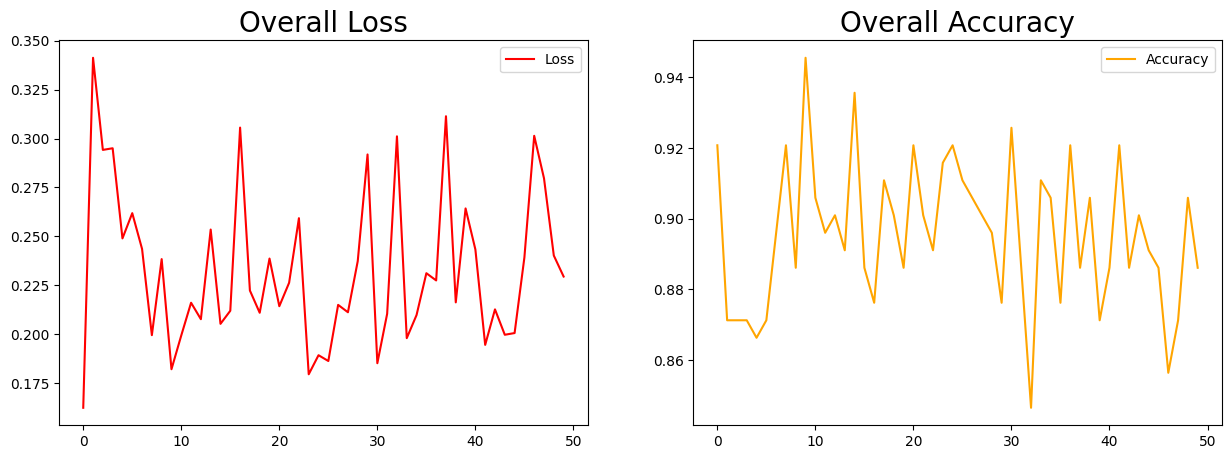

In [206]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist3['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist3['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" ></span> Xception

In [101]:
xception_model4 = tf.keras.applications.Xception(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in xception_model4.layers:
    layer.trainable=False
xception_model4.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [102]:
class_num=len(pd.unique(y_train))
model4=keras.models.Sequential()
model4.add(xception_model4)
model4.add(keras.layers.Dropout(.4))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(512,activation=tf.nn.relu))
model4.add(keras.layers.Dropout(.5)) 
model4.add(keras.layers.Dense(class_num,activation='softmax'))
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 37640234 (143.59 MB)
Trainable params: 1

In [103]:
model4.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model4.fit(X_train,y_train,epochs=50)

Epoch 1/50


2023-12-16 15:13:12.696966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 3s 42ms/step - loss: 6.2000 - accuracy: 0.5990
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 1.5285 - accuracy: 0.7673
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 1.5225 - accuracy: 0.8317
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 1.9870 - accuracy: 0.7723
Epoch 5/50
7/7 [==============================] - 0s 28ms/step - loss: 0.9540 - accuracy: 0.8663
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 0.7422 - accuracy: 0.8366
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 0.4342 - accuracy: 0.9158
Epoch 8/50
7/7 [==============================] - 0s 29ms/step - loss: 0.3678 - accuracy: 0.9109
Epoch 9/50
7/7 [==============================] - 0s 28ms/step - loss: 0.2481 - accuracy: 0.9257
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 0.1639 - accuracy: 0.9455
Epoch 11/50
7/7 [=======================

In [104]:
score, acc = model4.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 1s 312ms/step - loss: 0.6436 - accuracy: 0.9020
Test Loss = 0.6436491012573242
Test Accuracy = 0.9019607901573181


In [105]:
hist4=pd.DataFrame(hist.history)
hist4

loss  accuracy
0   6.199951  0.599010
1   1.528538  0.767327
2   1.522545  0.831683
3   1.986973  0.772277
4   0.954025  0.866337
5   0.742161  0.836634
6   0.434157  0.915842
7   0.367755  0.910891
8   0.248097  0.925743
9   0.163913  0.945545
10  0.097323  0.970297
11  0.129026  0.950495
12  0.093297  0.960396
13  0.071525  0.975248
14  0.052393  0.985148
15  0.062085  0.975248
16  0.035290  0.985148
17  0.033506  0.995049
18  0.028474  0.990099
19  0.027401  0.990099
20  0.059652  0.975248
21  0.034441  0.985148
22  0.016752  1.000000
23  0.036416  0.985148
24  0.016477  1.000000
25  0.021596  1.000000
26  0.039545  0.985148
27  0.023800  0.990099
28  0.010249  0.995049
29  0.013197  1.000000
30  0.026435  0.990099
31  0.019937  0.995049
32  0.007190  1.000000
33  0.007898  1.000000
34  0.019106  0.990099
35  0.016845  0.990099
36  0.007019  1.000000
37  0.012215  1.000000
38  0.006328  1.000000
39  0.010342  0.995049
40  0.013055  0.995049
41  0.009748  0.995049
42  0.010394  0.995049
43  0.003168  1.000000
44  0.008551  0.995049
45  0.005539  1.000000
46  0.012367  0.995049
47  0.004791  1.000000
48  0.009947  1.000000
49  0.008480  1.000000

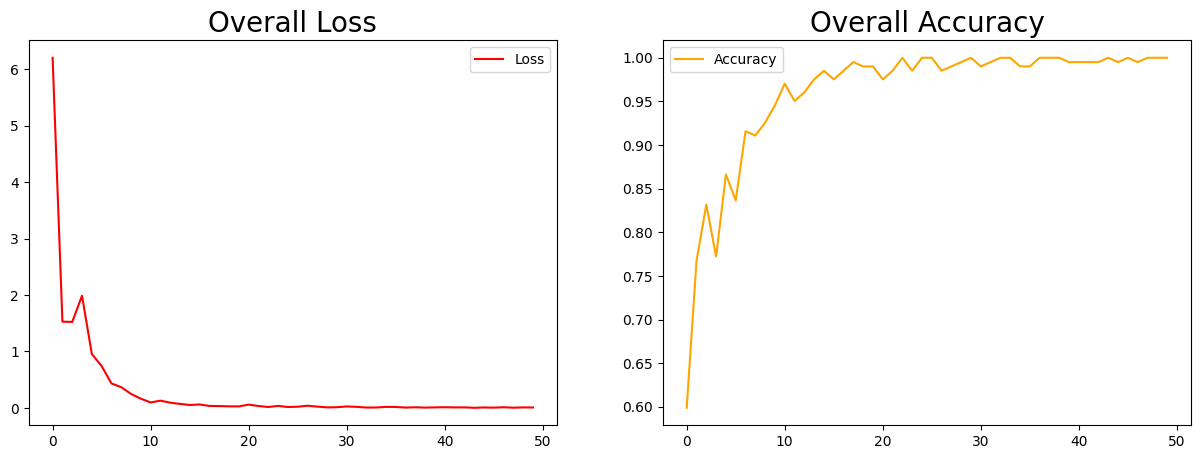

In [106]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist4['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist4['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" ></span>EfficientNetB2

In [107]:
efficient_model2 = tf.keras.applications.EfficientNetB2(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in efficient_model2.layers:
    layer.trainable=False
efficient_model2.summary()

31790344/31790344 [==============================] - 2s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [108]:
class_num=len(pd.unique(y_train))
model2=keras.models.Sequential()
model2.add(efficient_model2)
model2.add(keras.layers.Dropout(.2))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(512,activation='relu'))
model2.add(keras.layers.Dropout(.5)) 
model2.add(keras.layers.Dense(class_num,activation='relu'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 4, 4, 1408)        7768569   
 )                                                               
                                                                 
 dropout_14 (Dropout)        (None, 4, 4, 1408)        0         
                                                                 
 flatten_5 (Flatten)         (None, 22528)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               11534848  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                      

In [109]:
model2.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model2.fit(X_train,y_train,epochs=75)

Epoch 1/75


2023-12-16 15:14:20.082225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 11s 30ms/step - loss: 4.1014 - accuracy: 0.5297
Epoch 2/75
7/7 [==============================] - 0s 26ms/step - loss: 1.4867 - accuracy: 0.5644
Epoch 3/75
7/7 [==============================] - 0s 27ms/step - loss: 0.6931 - accuracy: 0.5891
Epoch 4/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.4901
Epoch 5/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.4653
Epoch 6/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.4802
Epoch 7/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.4653
Epoch 8/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 9/75
7/7 [==============================] - 0s 27ms/step - loss: 0.6931 - accuracy: 0.5248
Epoch 10/75
7/7 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 0.5198
Epoch 11/75
7/7 [======================

In [110]:
score, acc = model2.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 3s 542ms/step - loss: 0.6931 - accuracy: 0.7059
Test Loss = 0.6931471824645996
Test Accuracy = 0.7058823704719543


In [111]:
hist2=pd.DataFrame(hist.history)
hist2

loss  accuracy
0   4.101406  0.529703
1   1.486726  0.564356
2   0.693147  0.589109
3   0.693147  0.490099
4   0.693147  0.465347
..       ...       ...
70  0.693147  0.425743
71  0.693147  0.559406
72  0.693147  0.475248
73  0.693147  0.504951
74  0.693147  0.549505

[75 rows x 2 columns]

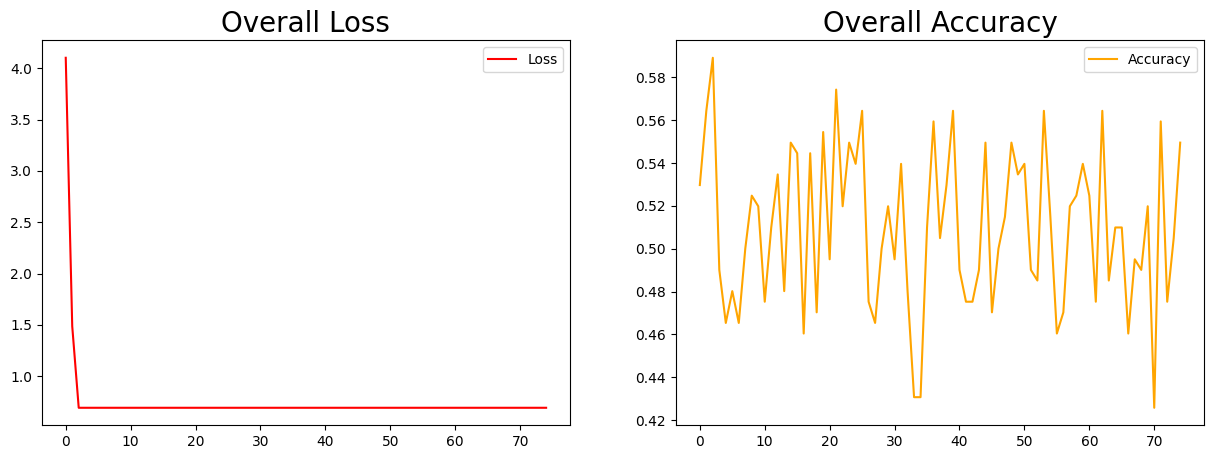

In [112]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist2['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist2['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" ></span>VGG16

In [113]:
vgg16_model = tf.keras.applications.VGG16(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in vgg16_model.layers:
    layer.trainable=False
vgg16_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [114]:
class_num=len(pd.unique(y_train))
model=keras.models.Sequential()
model.add(vgg16_model)
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.5)) 
model.add(keras.layers.Dense(class_num,activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout_16 (Dropout)        (None, 4, 4, 512)         0         
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 18910530 (72.14 MB)
Trainable params: 41

In [115]:
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=50)

Epoch 1/50


2023-12-16 15:14:51.770553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 3s 96ms/step - loss: 9.0580 - accuracy: 0.5050
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 49.0772 - accuracy: 0.7822
Epoch 3/50
7/7 [==============================] - 0s 26ms/step - loss: 33.9690 - accuracy: 0.7723
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 13.1934 - accuracy: 0.7871
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 16.9181 - accuracy: 0.7871
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 3.8933 - accuracy: 0.8515
Epoch 7/50
7/7 [==============================] - 0s 27ms/step - loss: 2.6062 - accuracy: 0.8317
Epoch 8/50
7/7 [==============================] - 0s 27ms/step - loss: 7.6242 - accuracy: 0.7822
Epoch 9/50
7/7 [==============================] - 0s 26ms/step - loss: 4.1066 - accuracy: 0.8515
Epoch 10/50
7/7 [==============================] - 0s 26ms/step - loss: 4.8822 - accuracy: 0.8663
Epoch 11/50
7/7 [===================

In [116]:
score, acc = model.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 1s 603ms/step - loss: 7.5072 - accuracy: 0.8824
Test Loss = 7.507174491882324
Test Accuracy = 0.8823529481887817


In [117]:
hist1=pd.DataFrame(hist.history)
hist1

loss  accuracy
0    9.058034  0.504951
1   49.077232  0.782178
2   33.968998  0.772277
3   13.193436  0.787129
4   16.918142  0.787129
5    3.893253  0.851485
6    2.606167  0.831683
7    7.624184  0.782178
8    4.106616  0.851485
9    4.882245  0.866337
10   2.107253  0.871287
11  14.257153  0.881188
12   1.174699  0.876238
13   6.208337  0.886139
14   4.241705  0.881188
15   4.623538  0.920792
16   0.744177  0.896040
17   2.258580  0.900990
18   0.166215  0.945545
19   4.209185  0.925743
20   3.031327  0.886139
21   4.689321  0.915842
22   8.587980  0.896040
23   7.629643  0.920792
24   5.720001  0.915842
25  13.782917  0.935644
26   6.900131  0.920792
27   5.406883  0.950495
28   5.038137  0.935644
29   3.948060  0.940594
30   7.993632  0.930693
31   1.873307  0.930693
32   4.938288  0.900990
33   2.619236  0.970297
34   0.394460  0.950495
35   0.594615  0.930693
36   6.061632  0.950495
37   2.550835  0.950495
38   2.417684  0.940594
39   6.295903  0.960396
40   1.870522  0.960396
41   0.094205  0.975248
42   2.038528  0.960396
43   2.768620  0.960396
44   2.866472  0.955446
45   2.539853  0.975248
46   3.083924  0.965347
47   2.419922  0.960396
48   0.289092  0.980198
49   1.533554  0.980198

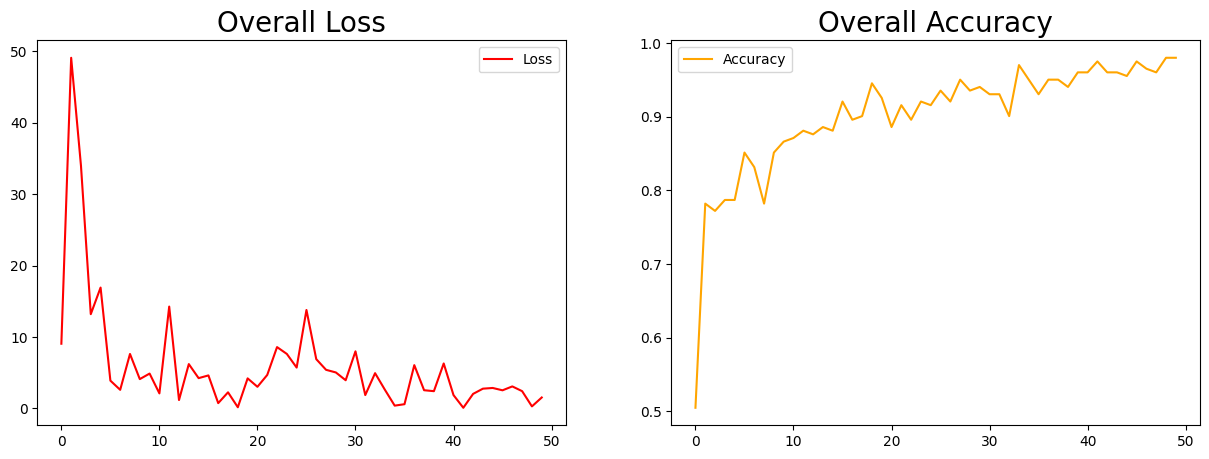

In [118]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist1['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" >Mobilenet </span>

In [119]:
mobilenet_model7 = tf.keras.applications.MobileNet(input_shape=(128,128,3),include_top=False,weights="imagenet")
for layer in mobilenet_model7.layers:
    layer.trainable=False
mobilenet_model7.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                 

In [120]:
class_num=len(pd.unique(y_train))
model7=keras.models.Sequential()
model7.add(mobilenet_model7)
model7.add(keras.layers.Dropout(.5))
model7.add(keras.layers.Flatten())
model7.add(keras.layers.Dense(512,activation=tf.nn.relu))
model7.add(keras.layers.Dropout(.5)) 
model7.add(keras.layers.Dense(class_num,activation='softmax'))
model7.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 4, 4, 1024)        0         
                                                                 
 flatten_7 (Flatten)         (None, 16384)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               8389120   
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 1026      
                                                      

In [121]:
model7.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model7.fit(X_train,y_train,epochs=60)

Epoch 1/60


2023-12-16 15:15:25.653784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 2s 13ms/step - loss: 7.2905 - accuracy: 0.6188
Epoch 2/60
7/7 [==============================] - 0s 12ms/step - loss: 1.2135 - accuracy: 0.8465
Epoch 3/60
7/7 [==============================] - 0s 12ms/step - loss: 1.4527 - accuracy: 0.8663
Epoch 4/60
7/7 [==============================] - 0s 12ms/step - loss: 1.1086 - accuracy: 0.8614
Epoch 5/60
7/7 [==============================] - 0s 12ms/step - loss: 0.8634 - accuracy: 0.8911
Epoch 6/60
7/7 [==============================] - 0s 13ms/step - loss: 0.2245 - accuracy: 0.9356
Epoch 7/60
7/7 [==============================] - 0s 12ms/step - loss: 0.2518 - accuracy: 0.9406
Epoch 8/60
7/7 [==============================] - 0s 12ms/step - loss: 0.0924 - accuracy: 0.9653
Epoch 9/60
7/7 [==============================] - 0s 13ms/step - loss: 0.1099 - accuracy: 0.9752
Epoch 10/60
7/7 [==============================] - 0s 13ms/step - loss: 0.0378 - accuracy: 0.9901
Epoch 11/60
7/7 [=======================

In [122]:
score, acc = model7.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 1s 127ms/step - loss: 0.5355 - accuracy: 0.9216
Test Loss = 0.5355073809623718
Test Accuracy = 0.9215686321258545


In [123]:
hist7=pd.DataFrame(hist.history)
hist7

loss  accuracy
0   7.290478  0.618812
1   1.213514  0.846535
2   1.452676  0.866337
3   1.108618  0.861386
4   0.863403  0.891089
5   0.224459  0.935644
6   0.251796  0.940594
7   0.092410  0.965347
8   0.109865  0.975248
9   0.037846  0.990099
10  0.025589  0.985148
11  0.004476  1.000000
12  0.043334  0.990099
13  0.015818  0.995049
14  0.009637  0.995049
15  0.009206  0.995049
16  0.000874  1.000000
17  0.000821  1.000000
18  0.000551  1.000000
19  0.011152  0.995049
20  0.000405  1.000000
21  0.004410  1.000000
22  0.000177  1.000000
23  0.001195  1.000000
24  0.004107  0.995049
25  0.000320  1.000000
26  0.000240  1.000000
27  0.000060  1.000000
28  0.000566  1.000000
29  0.000478  1.000000
30  0.000448  1.000000
31  0.000805  1.000000
32  0.000990  1.000000
33  0.000320  1.000000
34  0.001393  1.000000
35  0.000248  1.000000
36  0.000656  1.000000
37  0.000072  1.000000
38  0.000216  1.000000
39  0.001923  1.000000
40  0.000241  1.000000
41  0.000075  1.000000
42  0.000122  1.000000
43  0.006848  1.000000
44  0.000115  1.000000
45  0.000095  1.000000
46  0.003401  1.000000
47  0.009348  0.995049
48  0.000135  1.000000
49  0.001408  1.000000
50  0.000771  1.000000
51  0.000986  1.000000
52  0.000964  1.000000
53  0.000374  1.000000
54  0.022039  0.995049
55  0.002178  1.000000
56  0.016216  0.995049
57  0.017974  0.990099
58  0.019656  0.995049
59  0.024053  0.995049

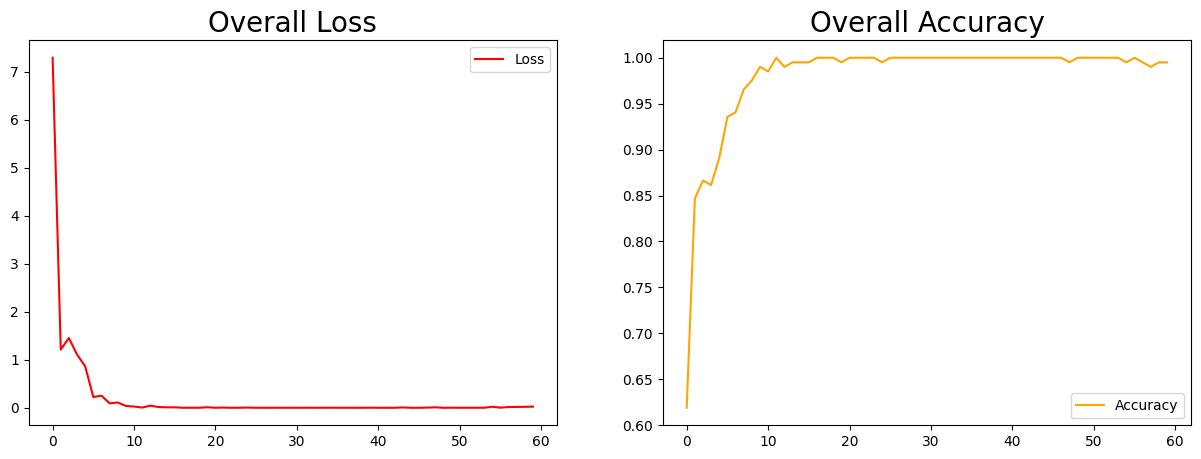

In [124]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist7['loss'],c='r',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist7['accuracy'],c='orange',label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

<B span style="color: red; font-size: 30px;" >Build Convolutional Neural Network (CNN) </span>

In [171]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,3)),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=2,
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 64)      8256      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 28800)           

In [172]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [173]:
model5.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
7/7 [==============================] - 2s 51ms/step - loss: 0.6765 - accuracy: 0.6733 - val_loss: 0.4972 - val_accuracy: 0.7843
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 0.5054 - accuracy: 0.8020 - val_loss: 0.4849 - val_accuracy: 0.7843
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.5487 - accuracy: 0.7426 - val_loss: 0.5005 - val_accuracy: 0.8039
Epoch 4/100
7/7 [==============================] - 0s 20ms/step - loss: 0.4598 - accuracy: 0.8168 - val_loss: 0.4673 - val_accuracy: 0.7843
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 0.4137 - accuracy: 0.8317 - val_loss: 0.4574 - val_accuracy: 0.8039
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.3697 - accuracy: 0.8515 - val_loss: 0.4587 - val_accuracy: 0.8039
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.3035 - accuracy: 0.8663 - val_loss: 0.3863 - val_accuracy: 0.8039
Epoch 8/100
7/7 [===

<B span style="color: red; font-size: 30px;" >Evalate Model</span>

In [174]:
Model_evaluation = model5.evaluate(X_test, y_test)
print(f"Loss: {Model_evaluation[0]*100:.2f} %\nAccuracy: {Model_evaluation[1]:.4f} %")

2/2 [==============================] - 0s 7ms/step - loss: 0.8360 - accuracy: 0.9020
Loss: 83.60 %
Accuracy: 0.9020 %


<B span style="color: red; font-size: 30px;" >Test Model</span>

In [175]:
y_predicted =model5.predict(X_test)
y_predicted = [1 if y>=0.5 else 0 for y in y_predicted] 
df = pd.DataFrame({"Y_test": y_test , "Y_predicted" : y_predicted})
df.head(8)

2/2 [==============================] - 0s 4ms/step


Y_test  Y_predicted
0       1            1
1       1            1
2       1            1
3       0            0
4       1            1
5       0            0
6       1            1
7       1            1

In [176]:
pd.DataFrame(y_predicted).value_counts()

1    37
0    14
Name: count, dtype: int64

<B span style="color: red; font-size: 30px;" >Plot Metrics</span>

In [177]:
conf= confusion_matrix(y_test, y_predicted)
print(conf)

[[12  3]
 [ 2 34]]


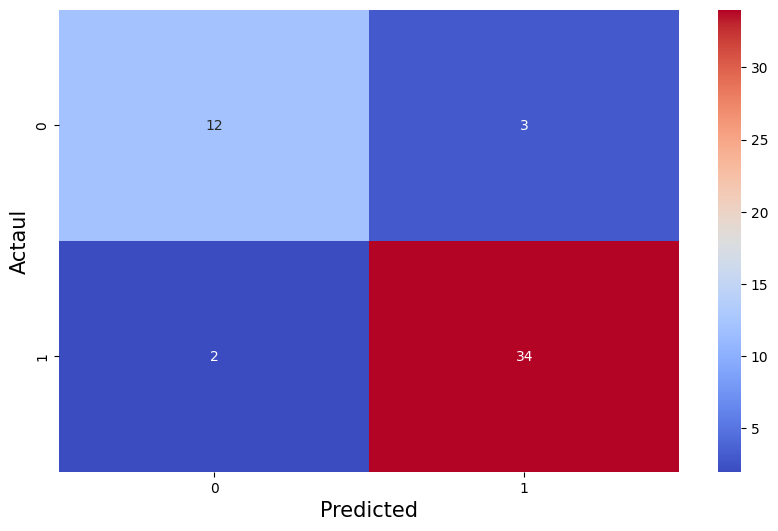

In [178]:
plt.figure(figsize=(10,6))
sns.heatmap(conf, cmap='coolwarm', annot=True)
plt.xlabel('Predicted', size=15)
plt.ylabel('Actaul', size=15)
plt.show()

In [179]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.92      0.94      0.93        36

    accuracy                           0.90        51
   macro avg       0.89      0.87      0.88        51
weighted avg       0.90      0.90      0.90        51



In [180]:
recall_1 = 25/(25+3)
recall_0 = 21/(21+2)
precision_1 = 25/(25+2)
precision_0 = 21/(21+3)

print(f'recall_1 is: {round(recall_1, 2)}')
print(f'recall_0 is: {round(recall_0, 2)}')
print(f'precision_1 is: {round(precision_1, 2)}')
print(f'precision_0 is: {round(precision_0, 2)}')

recall_1 is: 0.89
recall_0 is: 0.91
precision_1 is: 0.93
precision_0 is: 0.88


<B span style="color: red; font-size: 30px;" >Save Model</span>

In [181]:
tf.keras.models.save_model(model,'CNN.h5')

<B span style="color: red; font-size: 30px;" >Test No Tumor</span>

In [182]:
img = cv2.imread("/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/no/N19.JPG")
img = cv2.resize(img,(128, 128))
img = img / 255 
img = np.array(img)

In [183]:
img.shape

(128, 128, 3)

In [184]:
img = img.reshape(1,128,128,3)
img.shape

(1, 128, 128, 3)

In [185]:
res = model5.predict(img)
print(res[0][0])
if res >=0.5:
    print('Its a Tumor')
else:
    print('No, Its not a tumor')


1/1 [==============================] - 0s 45ms/step
0.00018516023
No, Its not a tumor


<B span style="color: red; font-size: 30px;" >Test Tumor</span>

In [186]:
img = cv2.imread("/kaggle/input/brain-tumor-dataset/brain_tumor_dataset/yes/Y100.JPG")
img = cv2.resize(img,(128, 128))
img = img / 255 
img = np.array(img)
img = img.reshape(1,128,128,3)
img.shape

(1, 128, 128, 3)

In [187]:
res = model5.predict(img)
print(res[0][0])
if res >=0.5:
    print('Its a Tumor')
else:
    print('No, Its not a tumor')


1/1 [==============================] - 0s 18ms/step
0.9977208
Its a Tumor


<B span style="color: red; font-size: 30px;"> Finally</span>

In [224]:
VGG16_score, VGG16_acc = model.evaluate(X_test, y_test)
print('VGG16_Test Loss =', VGG16_score)
print('VGG16_Test Accuracy =', VGG16_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

EfficientNetB2_score, EfficientNetB2_acc = model2.evaluate(X_test, y_test)
print('EfficientNetB2_Test Loss =', EfficientNetB2_score)
print('EfficientNetB2_Test Accuracy =', EfficientNetB2_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

ResNet50_score, ResNet50_acc = model3.evaluate(X_test, y_test)
print('ResNet50_Test Loss =', ResNet50_score)
print('ResNet50_Test Accuracy =', ResNet50_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

Xception_score, Xception_acc = model4.evaluate(X_test, y_test)
print('Xception_Test Loss =', Xception_score)
print('Xception_Test Accuracy =', Xception_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

CNN_score, CNN_acc = model5.evaluate(X_test, y_test)
print('CNN_Test Loss =', CNN_score)
print('CNN_Test Accuracy =', CNN_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

DenseNet121_score, DenseNet121_acc = model6.evaluate(X_test, y_test)
print('DenseNet121_Test Loss =', DenseNet121_score)
print('DenseNet121_Test Accuracy =', DenseNet121_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')

MobileNet_score, MobileNet_acc = model7.evaluate(X_test, y_test)
print('MobileNet_Test Loss =', MobileNet_score)
print('MobileNet_Test Accuracy =', MobileNet_acc)

print('---------------------------------------------------------------\n---------------------------------------------------------------')


2/2 [==============================] - 0s 22ms/step - loss: 7.5072 - accuracy: 0.8824
VGG16_Test Loss = 7.507174491882324
VGG16_Test Accuracy = 0.8823529481887817
---------------------------------------------------------------
---------------------------------------------------------------
2/2 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.7059
EfficientNetB2_Test Loss = 0.6931471824645996
EfficientNetB2_Test Accuracy = 0.7058823704719543
---------------------------------------------------------------
---------------------------------------------------------------
2/2 [==============================] - 0s 23ms/step - loss: 0.4844 - accuracy: 0.8431
ResNet50_Test Loss = 0.48442956805229187
ResNet50_Test Accuracy = 0.843137264251709
---------------------------------------------------------------
---------------------------------------------------------------
2/2 [==============================] - 0s 24ms/step - loss: 0.6436 - accuracy: 0.9020
Xception_Test L

<B span style="color: red; font-size: 30px;" >END</span>